# **Required Downloads**

In [1]:
!pip install -q transformers
!pip install -q contractions
!pip install -q autocorrect

# **Required Imports**

In [2]:

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import RobertaTokenizer,TFRobertaForSequenceClassification
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from transformers import ElectraTokenizer,TFElectraForSequenceClassification
from transformers import GPT2Tokenizer,TFGPT2ForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification,TFPreTrainedModel

import time

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

import tensorflow as tf
import json

import numpy as np
import pandas as pd


import os
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

import contractions
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from autocorrect import Speller



# **Data Prepration**

## Importing Data
- The following cell is importing data from google drive and storing the files to /home/Emotiondata directory.
- Data Source: 
> https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DataDir = '/home/EmotionData/'
!mkdir /home/EmotionData
!unzip /content/drive/MyDrive/archive.zip 
!mv /content/*.txt /home/EmotionData

mkdir: cannot create directory ‘/home/EmotionData’: File exists
Archive:  /content/drive/MyDrive/archive.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


## Loading Data
- The Following cell loads train, validation and test data to variables 
- Used Sources: 
>https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas

In [5]:
def readDataEmotionData1(dataPath):
  data = pd.read_csv(DataDir+dataPath, sep=";", header=None, names = ['Text','Label'])
  return data;

trainData = readDataEmotionData1('train.txt')
valData = readDataEmotionData1('val.txt')
testData = readDataEmotionData1('test.txt')
# Shows how the data looks in the padas DataFrame after loading 
trainData.head()

,Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## About the Data


In [6]:
# The following function adds length coloum to pandas Dataframe
def addTextLength(dataFrame):
  lengthData = []
  for i in dataFrame['Text']:
    lengthData.append(len(i))
  dataFrame=dataFrame.assign(Length=lengthData)
  return dataFrame
trainData = addTextLength(trainData)
valData = addTextLength(valData)
testData = addTextLength(testData)
valData.head()

,Text,Label,Length
0,im feeling quite sad and sorry for myself but ...,sadness,69
1,i feel like i am still looking at a blank canv...,sadness,70
2,i feel like a faithful servant,love,30
3,i am just feeling cranky and blue,anger,33
4,i can have for a treat or if i am feeling festive,joy,49


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


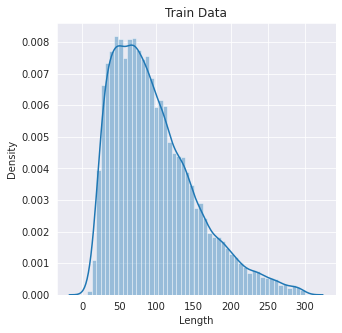

In [7]:
# This shows the distrubution of the number of characters length of the Text.
def plotDestrubrition(data,name):
  sns.set_style('darkgrid')
  plt.figure(figsize=(5,5))
  plt.title(name)
  sns.distplot(data)
plotDestrubrition(trainData['Length'],'Train Data')

In [8]:
maxSentanceLength = 300
trainData.describe()

,Length
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


## Text Prepration
- Decontracted: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/
- Spell check
- About Formatted Data
- Labels One hot enconding
- Text Enconding using Model specific, ex. BertTokenizer, RobertaTokenizer,etc.

In [9]:
def Decontracted(DataFrame):
  for i, text in enumerate(DataFrame['Text']):
    DataFrame['Text'][i] = contractions.fix(text)
  return DataFrame
trainData = Decontracted(trainData)
valData = Decontracted(valData)
testData = Decontracted(testData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# from autocorrect import Speller
# def SpellCheck(DataFrame):
#   spell = Speller(lang='en')
#   for i, text in enumerate(DataFrame['Text']):
#       DataFrame['Text'][i] = str(spell(text))
#   return DataFrame

# trainData = SpellCheck(trainData)
# valData = SpellCheck(valData)
# testData = SpellCheck(testData)

In [11]:
def LabelEncoding(DataFrame):
  labels = []
  encodeVectorizer = CountVectorizer(analyzer = "word", tokenizer = None,lowercase=True, preprocessor = None, stop_words = None)
  encodedLabels = encodeVectorizer.fit_transform(DataFrame['Label']).toarray()
  LabelsNames = list(encodeVectorizer.get_feature_names())
  for i in DataFrame['Label']:
    labels.append((list(LabelsNames).index(i)))
  return labels,LabelsNames
encodedTrainLabels,TrainLabelFeatureNames = LabelEncoding(trainData)
encodedValLabels,ValLabelFeatureNames = LabelEncoding(valData)
encodedTestLabels,TestLabelFeatureNames = LabelEncoding(testData)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
def TextEncoding(tokenizerType,
                 dataTextList, 
                 LabelList, 
                 batchSize,
                 shufflingParameter,
                 maxLen):
  tokenizer = AutoTokenizer.from_pretrained(tokenizerType)
  textEncodings = tokenizer(dataTextList,
                            truncation=True, 
                            max_length = maxLen,
                            padding="max_length")
  
  dataset = tf.data.Dataset.from_tensor_slices((
    dict(textEncodings),
    LabelList
    ))
  dataset = dataset.shuffle(shufflingParameter).batch(batchSize)
  return dataset,tokenizer

# **Model Bulding and Training**

In [13]:
!mkdir /models/
!mkdir /models/Stats/
timeData = pd.DataFrame(columns= ['Training(min) ', 'Evalution(min)']).rename_axis('Models', axis=1)


mkdir: cannot create directory ‘/models/’: File exists
mkdir: cannot create directory ‘/models/Stats/’: File exists


In [13]:
def CreateModel(model,
                numLabels,
                maxSentanceLength,
                input_ids,
                mask):
  embeddings = model(input_ids,mask)[0]
  layer = tf.keras.layers.Dense(1000,activation='relu')(embeddings)
  layer = tf.keras.layers.BatchNormalization()(layer)
  outputLayer = tf.keras.layers.Dense(6,activation='softmax',name='outputs')(layer)
  testModel = tf.keras.Model(inputs=[input_ids,mask],outputs=outputLayer)
  return testModel

In [14]:
def plotEpochs(hist,
               histKeys,
               Title,
               Ylabel,
               Xlabel = "Epochs",
               savePlotPath = ""):
  legends = []
  for i in histKeys:
    plt.plot(hist.history[i])
    legends.append(i)
  plt.title(Title)
  plt.ylabel(Ylabel)
  plt.xlabel(Xlabel)
  plt.legend(legends)
  plt.show()
  if len(savePlotPath) > 0:
    plt.savefig(savePlotPath, format="svg")


In [15]:
'''
While Trying make custom matrices, I found this post in which they have coded what I was attempting.
**Note** I changed the definition name for my own purpose
Source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
'''
from keras import backend as K

def Recalls(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision_Marco(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_Macro(y_true, y_pred):
    precision = Precision_Marco(y_true, y_pred)
    recall = Recalls(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
def trainModel(
    # Default Parameters
    maxSentanceLength = 275,
    BatchSize = 16,
    shufflingParameter = 1000,
    Learning_rate=5e-5,
    Epochs=4,
    numLabels = len(encodedTrainLabels),
    ModelName = 'bert-base-uncased',
    ModelMetrics = ['accuracy'],
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    ModelTrainData = list(trainData['Text']),
    TrainLabels = encodedTrainLabels,
    ModelValData = list(valData['Text']),
    ValLabels = encodedValLabels):
  valDataSet,tokenizer = TextEncoding(ModelName,
                                      ModelValData,
                                      ValLabels,
                                      BatchSize,
                                      shufflingParameter,
                                      maxSentanceLength)
  
  trainDataSet,tokenizer = TextEncoding(ModelName,
                                        ModelTrainData,
                                        TrainLabels,
                                        BatchSize,
                                        shufflingParameter,
                                        maxSentanceLength)

  
  input_ids = tf.keras.layers.Input(shape=(maxSentanceLength,),name="input_ids", dtype='int32')
  mask = tf.keras.layers.Input(shape=(maxSentanceLength,),name="attention_mask",dtype='int32')
  tokenIds = tf.keras.layers.Input(shape=(maxSentanceLength,),name="token_ids",dtype='int32')

  modelPreTrianed = TFAutoModelForSequenceClassification.from_pretrained(ModelName,
                                                               num_labels=6)
  model = CreateModel(modelPreTrianed,
                      numLabels,
                      maxSentanceLength,
                      input_ids = input_ids,
                      mask = mask)
  model.compile(optimizer=optimizer, 
                loss=loss, 
                metrics=ModelMetrics)
  StartTime = time.time()
  hist = model.fit(trainDataSet,
          epochs=Epochs,
          batch_size=BatchSize,
          validation_data =valDataSet)
  EndTime = time.time()
  TrainingTime = (EndTime-StartTime)/60
  return tokenizer,hist,model, modelPreTrianed,TrainingTime



In [17]:
def saveModelWeights(model,
                     path):
  model.save_weights(path)
  print('The Model Saved')

def saveTrasformerTokenizer(tokenizer,
                            path):
  tokenizer.save_pretrained(path)
  print('The Tokenizer Saved')

def savePreTrainedTransformerModel(model,
                                   path):
  model.save_pretrained(path)
  print('The PreTrained Transformer Model Saved')

  

In [18]:
def doTrainningModel(ModelName,
                     ModelType):
  Tokenizer,history,model,PreTrainedModel,TrainningTime = trainModel(ModelMetrics = ['accuracy',F1_Macro],ModelName=ModelType)
  plotEpochs(hist = history,
            histKeys = ['accuracy','val_accuracy','F1_Macro','val_F1_Macro'],
            Title = ModelName +" Accuracy Graph",
            Ylabel = "Accuracy",
            savePlotPath = '/models/'+ModelName+'/Accuracy.svg')
  plotEpochs(hist = history,
            histKeys = ['loss','val_loss'],
            Title = ModelName+ "Loss Graph",
            Ylabel = "Loss",
            savePlotPath = "/models/"+ModelName+"/Loss.svg" )
  saveModelWeights(model,
                  '/models/'+ModelName+'/'+ModelName+'Weights.h5')

  savePreTrainedTransformerModel(PreTrainedModel,
                                '/models/'+ModelName+'/'+ModelName+'PreTrainedModel')
  saveTrasformerTokenizer(Tokenizer,
                          '/models/'+ModelName+'/'+ModelName+'Tokenizer/')
  timeData.loc[ModelName] = [TrainningTime,'NaN']
  timeData.to_csv('/models/Stats/TimeData.csv',index=True,index_label='Models')
  model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1000/1000 [==============================] - 589s 573ms/step - loss: 0.4823 - accuracy: 0.8376 - F1_Macro: 1.3009 - val_loss: 0.1751 - val_accuracy: 0.9360 - val_F1_Macro: 0.9780
Epoch 2/4
1000/1000 [==============================] - 570s 570ms/step - loss: 0.2020 - accuracy: 0.9294 - F1_Macro: 1.0033 - val_loss: 0.1378 - val_accuracy: 0.9400 - val_F1_Macro: 0.9877
Epoch 3/4
1000/1000 [==============================] - 570s 570ms/step - loss: 0.1511 - accuracy: 0.9429 - F1_Macro: 0.9944 - val_loss: 0.1706 - val_accuracy: 0.9330 - val_F1_Macro: 1.0076
Epoch 4/4
1000/1000 [==============================] - 569s 569ms/step - loss: 0.1241 - accuracy: 0.9506 - F1_Macro: 0.9863 - val_loss: 0.1351 - val_accuracy: 0.9365 - val_F1_Macro: 0.9866


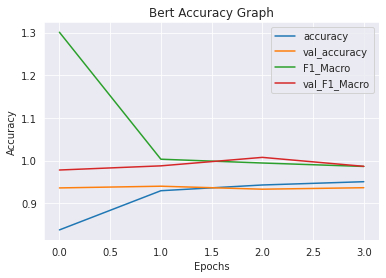

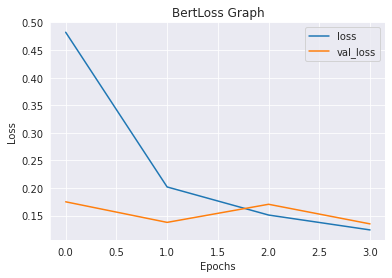

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109486854  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]']         
 fication)                      logits=(None, 6),                                                 
                   

<Figure size 432x288 with 0 Axes>

In [20]:
# Bert Model
!mkdir /models/Bert
!mkdir /models/Bert/BertPreTrainedModel/
!mkdir /models/Bert/BertTokenizer/

doTrainningModel('Bert',
                 'bert-base-uncased')

In [19]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,40.030757,NaN
DistilBert,20.504260,NaN


mkdir: cannot create directory ‘/models/DistilBert’: File exists
mkdir: cannot create directory ‘/models/DistilBert/DistilBertPreTrainedModel/’: File exists
mkdir: cannot create directory ‘/models/DistilBert/DistilBertTokenizer/’: File exists


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_57', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/4
1000/1000 [==============================] - 298s 290ms/step - loss: 0.4336 - accuracy: 0.8568 - F1_Macro: 1.2003 - val_loss: 0.1924 - val_accuracy: 0.9290 - val_F1_Macro: 1.0101
Epoch 2/4
1000/1000 [==============================] - 288s 288ms/step - loss: 0.1663 - accuracy: 0.9358 - F1_Macro: 1.0021 - val_loss: 0.1908 - val_accuracy: 0.9295 - val_F1_Macro: 0.9933
Epoch 3/4
1000/1000 [==============================] - 288s 288ms/step - loss: 0.1300 - accuracy: 0.9488 - F1_Macro: 0.9858 - val_loss: 0.1638 - val_accuracy: 0.9405 - val_F1_Macro: 0.9824
Epoch 4/4
1000/1000 [==============================] - 289s 289ms/step - loss: 0.0976 - accuracy: 0.9645 - F1_Macro: 0.9716 - val_loss: 0.2338 - val_accuracy: 0.9370 - val_F1_Macro: 0.9595


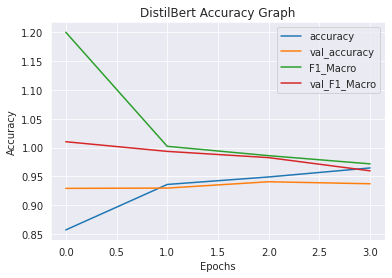

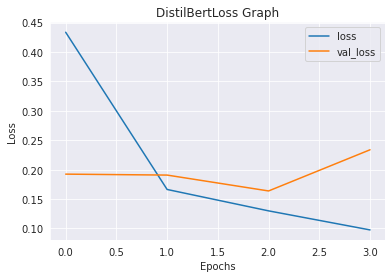

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66958086   ['input_ids[0][0]',              
 assification (TFDistilBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 6),                                                 
                 

<Figure size 432x288 with 0 Axes>

In [22]:
# DistilBert Model
!mkdir /models/DistilBert
!mkdir /models/DistilBert/DistilBertPreTrainedModel/
!mkdir /models/DistilBert/DistilBertTokenizer/

doTrainningModel('DistilBert',
                 'distilbert-base-uncased')

In [20]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,40.030757,NaN
DistilBert,20.504260,NaN


mkdir: cannot create directory ‘/models/Roberta’: File exists
mkdir: cannot create directory ‘/models/Roberta/RobertaPreTrainedModel/’: File exists
mkdir: cannot create directory ‘/models/Roberta/RobertaTokenizer/’: File exists


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
1000/1000 [==============================] - 591s 576ms/step - loss: 0.5070 - accuracy: 0.8296 - F1_Macro: 1.3149 - val_loss: 0.2440 - val_accuracy: 0.9225 - val_F1_Macro: 0.9707
Epoch 2/4
1000/1000 [==============================] - 573s 573ms/step - loss: 0.2215 - accuracy: 0.9231 - F1_Macro: 1.0128 - val_loss: 0.1571 - val_accuracy: 0.9380 - val_F1_Macro: 0.9870
Epoch 3/4
1000/1000 [==============================] - 574s 574ms/step - loss: 0.1805 - accuracy: 0.9306 - F1_Macro: 1.0063 - val_loss: 0.1637 - val_accuracy: 0.9335 - val_F1_Macro: 0.9935
Epoch 4/4
1000/1000 [==============================] - 574s 574ms/step - loss: 0.1630 - accuracy: 0.9357 - F1_Macro: 1.0041 - val_loss: 0.1965 - val_accuracy: 0.9260 - val_F1_Macro: 1.0111


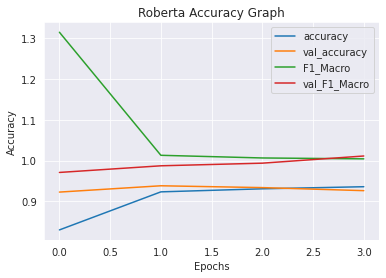

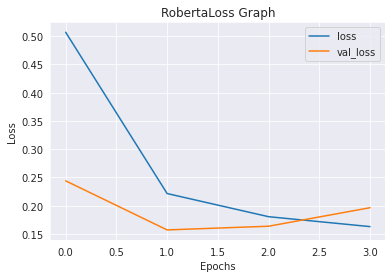

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_roberta_for_sequence_classi  TFSequenceClassifie  124650246  ['input_ids[0][0]',              
 fication (TFRobertaForSequence  rOutput(loss=None,               'attention_mask[0][0]']         
 Classification)                logits=(None, 6),                                                 
                   

<Figure size 432x288 with 0 Axes>

In [21]:
# Roberta Model
!mkdir /models/Roberta
!mkdir /models/Roberta/RobertaPreTrainedModel/
!mkdir /models/Roberta/RobertaTokenizer/

doTrainningModel('Roberta',
                 'roberta-base')

In [19]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,40.030757,NaN
DistilBert,20.504260,NaN
Roberta,39.350323,NaN


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.9M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1000/1000 [==============================] - 174s 158ms/step - loss: 0.6684 - accuracy: 0.7651 - F1_Macro: 1.5401 - val_loss: 0.3509 - val_accuracy: 0.8925 - val_F1_Macro: 1.0683
Epoch 2/4
1000/1000 [==============================] - 155s 155ms/step - loss: 0.2407 - accuracy: 0.9169 - F1_Macro: 1.0302 - val_loss: 0.1881 - val_accuracy: 0.9360 - val_F1_Macro: 0.9904
Epoch 3/4
1000/1000 [==============================] - 156s 156ms/step - loss: 0.1768 - accuracy: 0.9344 - F1_Macro: 1.0052 - val_loss: 0.1968 - val_accuracy: 0.9295 - val_F1_Macro: 0.9727
Epoch 4/4
1000/1000 [==============================] - 157s 157ms/step - loss: 0.1525 - accuracy: 0.9384 - F1_Macro: 0.9977 - val_loss: 0.1787 - val_accuracy: 0.9355 - val_F1_Macro: 0.9887


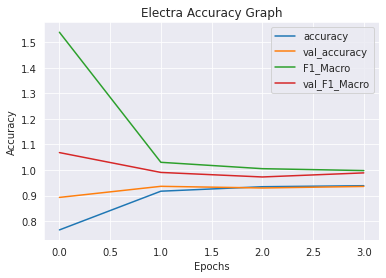

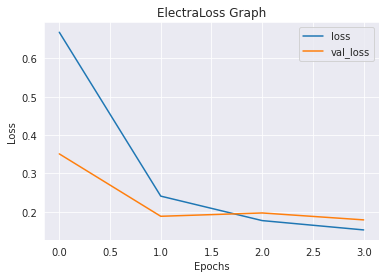

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_electra_for_sequence_classi  TFSequenceClassifie  13550342   ['input_ids[0][0]',              
 fication (TFElectraForSequence  rOutput(loss=None,               'attention_mask[0][0]']         
 Classification)                logits=(None, 6),                                                 
                 

<Figure size 432x288 with 0 Axes>

In [23]:
# Electra Model
!mkdir /models/Electra
!mkdir /models/Electra/ElectraPreTrainedModel/
!mkdir /models/Electra/ElectraTokenizer/

doTrainningModel('Electra',
                 'google/electra-small-discriminator')

In [20]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,40.030757,NaN
DistilBert,20.504260,NaN
Roberta,39.350323,NaN
Electra,11.444869,NaN


mkdir: cannot create directory ‘/models/MobileBert’: File exists
mkdir: cannot create directory ‘/models/MobileBert/MobileBertPreTrainedModel/’: File exists
mkdir: cannot create directory ‘/models/MobileBert/MobileBertTokenizer/’: File exists


All model checkpoint layers were used when initializing TFMobileBertForSequenceClassification.

Some layers of TFMobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1000/1000 [==============================] - 436s 385ms/step - loss: 0.9735 - accuracy: 0.6456 - F1_Macro: 1.9570 - val_loss: 0.6256 - val_accuracy: 0.7680 - val_F1_Macro: 1.4507
Epoch 2/4
1000/1000 [==============================] - 373s 373ms/step - loss: 0.3724 - accuracy: 0.8788 - F1_Macro: 1.1663 - val_loss: 0.2573 - val_accuracy: 0.8970 - val_F1_Macro: 1.0505
Epoch 3/4
1000/1000 [==============================] - 373s 373ms/step - loss: 0.2677 - accuracy: 0.9158 - F1_Macro: 1.0627 - val_loss: 0.2862 - val_accuracy: 0.9085 - val_F1_Macro: 1.0535
Epoch 4/4
1000/1000 [==============================] - 371s 371ms/step - loss: 0.2358 - accuracy: 0.9237 - F1_Macro: 1.0628 - val_loss: 0.2362 - val_accuracy: 0.9190 - val_F1_Macro: 1.0267


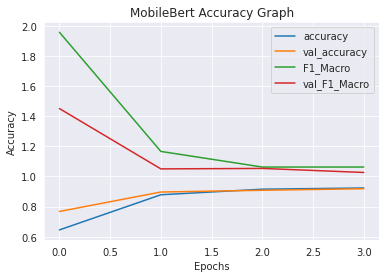

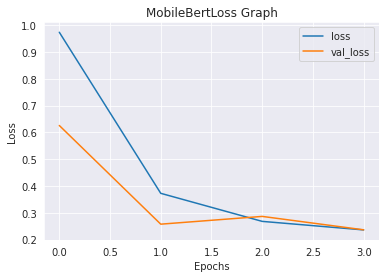

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_mobile_bert_for_sequence_cl  TFSequenceClassifie  24584966   ['input_ids[0][0]',              
 assification (TFMobileBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 6),                                                 
                   

<Figure size 432x288 with 0 Axes>

In [21]:
# MobileBert Model
!mkdir /models/MobileBert
!mkdir /models/MobileBert/MobileBertPreTrainedModel/
!mkdir /models/MobileBert/MobileBertTokenizer/

doTrainningModel('MobileBert',
                 'google/mobilebert-uncased')

In [ ]:
!gcloud auth login
!gsutil cp -r /models/* gs://emotion-models/


# **Model Validation**

In [29]:
class PredictEmotion:
  def __init__(self,
               modelName, 
               modelPath,
               modelPreTrainedPath,
               isTokenizerFast = False, 
               numLabels = 6,
               thrushHold = 0.1):
    self.modelPreTrainedPath = modelPreTrainedPath
    self.modelName = modelName
    self.modelPath = modelPath
    self.isTokenizerFast = isTokenizerFast
    self.numLabels = numLabels
    self.model = self.MakeModelArchitecture()
    self.loadModelWeights()
    self.tokenizer = self.makeTokenizer()
    self.spell = Speller(lang='en')
    self.emotionTypes = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise','other']
    self.thrushHold = thrushHold

  def MakeModelArchitecture(self):
    model = TFAutoModelForSequenceClassification.from_pretrained(self.modelPreTrainedPath, 
                                                                 local_files_only=True)

    input_ids = tf.keras.layers.Input(shape=(200,),name="input_ids", dtype='int32')
    mask = tf.keras.layers.Input(shape=(200,),name="attention_mask",dtype='int32')
    embeddings = model(input_ids,attention_mask=mask)[0]
    layer = tf.keras.layers.Dense(1000,activation='relu')(embeddings)
    layer = tf.keras.layers.BatchNormalization()(layer)
    outputLayer = tf.keras.layers.Dense(6,activation='softmax',name='outputs')(layer)
    ModelArchitecture = tf.keras.Model(inputs=[input_ids,mask],outputs=outputLayer)
    return ModelArchitecture

  def loadModelWeights(self):
    self.model.load_weights(self.modelPath)
  
  def makeTokenizer(self):
    return AutoTokenizer.from_pretrained(self.modelName)
  
  def TextPrepration(self,text):
    DecontractedText = contractions.fix(text)
    # SpelledText = str(self.spell(DecontractedText))
    textEncodings = self.tokenizer(DecontractedText,
                            truncation=True, 
                            max_length = 200,
                            padding="max_length", 
                            return_tensors='tf')
    return {
      'input_ids': tf.cast(textEncodings['input_ids'],tf.int32),
      'attention_mask': tf.cast(textEncodings['attention_mask'],tf.int32)}

  def PredictTextEmotion(self,text):
    prepratedText = self.TextPrepration(text)
    emotion = self.model.predict(prepratedText) 
    predictedEmotion = np.argmax(emotion)
    highestProb = emotion[0][predictedEmotion]
    if highestProb < self.thrushHold:
      return self.emotionTypes[len(self.emotionTypes)-1], self.thrushHold
    else:
      return self.emotionTypes[predictedEmotion],highestProb


In [40]:
def predictEmotionTestData(predict,testDataSet):
  predictedLabels = []
  startTime = time.time()
  for i in testDataSet:
    # print(i)
    emotion,prob = predict.PredictTextEmotion(i)
    predictedLabels.append(emotion)
  endTime = time.time()
  elapasedTime = (endTime-startTime)/60
  return elapasedTime,predictedLabels


In [53]:
F1ModelScores = pd.DataFrame(index=['anger', 'fear', 'joy', 'love' ,'sadness', 'surprise', 'accuracy',
       'macro avg', 'weighted avg']).rename_axis('Emotion', axis=1)

In [32]:
def appendF1ModelScores(trueEmotionLabels,
                        predictedEmotionLabels,
                        F1ScoresDataFrame,
                        AppendingModelName):
  f1Report = classification_report(trueEmotionLabels, predictedEmotionLabels,output_dict=True)
  f1_scores = pd.DataFrame(f1Report).transpose()
  f1_scores = f1_scores.loc[:,['f1-score']]
  scores = list(f1_scores['f1-score'][:])
  F1ScoresDataFrame[AppendingModelName] = scores
  return F1ScoresDataFrame

In [54]:
# Bert Evalution
predictClass = PredictEmotion('/models/Bert/BertTokenizer/',
                              '/models/Bert/BertWeights.h5',
                              '/models/Bert/BertPreTrainedModel/')
elapasedTime,predVal = predictEmotionTestData(predictClass,list(testData['Text']))
timeData['Evalution(min)']['Bert'] = elapasedTime
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    predVal,
                    F1ModelScores,
                    'Bert')

Some layers from the model checkpoint at /models/Bert/BertPreTrainedModel/ were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /models/Bert/BertPreTrainedModel/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
/usr/local/lib/python3.7/dist-packages/ipyk

In [55]:
# DistilBert Evalution
predictClass = PredictEmotion('/models/DistilBert/DistilBertTokenizer/',
                              '/models/DistilBert/DistilBertWeights.h5',
                              '/models/DistilBert/DistilBertPreTrainedModel/')
elapasedTime,predVal = predictEmotionTestData(predictClass,list(testData['Text']))
timeData['Evalution(min)']['DistilBert'] = elapasedTime
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    predVal,
                    F1ModelScores,
                    'DistilBert')

Some layers from the model checkpoint at /models/DistilBert/DistilBertPreTrainedModel/ were not used when initializing TFDistilBertForSequenceClassification: ['dropout_57']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /models/DistilBert/DistilBertPreTrainedModel/ and are newly initialized: ['dropout_221']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/

In [57]:
# Electra Evalution
predictClass = PredictEmotion('/models/Electra/ElectraTokenizer/',
                              '/models/Electra/ElectraWeights.h5',
                              '/models/Electra/ElectraPreTrainedModel/')
elapasedTime,predVal = predictEmotionTestData(predictClass,list(testData['Text']))
timeData['Evalution(min)']['Electra'] = elapasedTime
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    predVal,
                    F1ModelScores,
                    'Electra')

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /models/Electra/ElectraPreTrainedModel/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
# Roberta Evalution
predictClass = PredictEmotion('/models/Roberta/RobertaTokenizer/',
                              '/models/Roberta/RobertaWeights.h5',
                              '/models/Roberta/RobertaPreTrainedModel/')
elapasedTime,predVal = predictEmotionTestData(predictClass,list(testData['Text']))
timeData['Evalution(min)']['Roberta'] = elapasedTime
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    predVal,
                    F1ModelScores,
                    'Roberta')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /models/Roberta/RobertaPreTrainedModel/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
# MobileBert Evalution
predictClass = PredictEmotion('/models/MobileBert/MobileBertTokenizer/',
                              '/models/MobileBert/MobileBertWeights.h5',
                              '/models/MobileBert/MobileBertPreTrainedModel/')
elapasedTime,predVal = predictEmotionTestData(predictClass,list(testData['Text']))
timeData['Evalution(min)']['MobileBert'] = elapasedTime
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    predVal,
                    F1ModelScores,
                    'MobileBert')

Some layers from the model checkpoint at /models/MobileBert/MobileBertPreTrainedModel/ were not used when initializing TFMobileBertForSequenceClassification: ['dropout_49']
- This IS expected if you are initializing TFMobileBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFMobileBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFMobileBertForSequenceClassification were initialized from the model checkpoint at /models/MobileBert/MobileBertPreTrainedModel/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMobileBertForSequenceClassification for predictions without further

In [64]:
F1ModelScores.to_csv('/models/Stats/ModelPerformance.csv',index=True,index_label='Emotion')
timeData.to_csv('/models/Stats/TimeData.csv',index=True,index_label='Models')



In [65]:
!gsutil cp -r /models/Stats/* gs://emotion-models/Stats/

Copying file:///models/Stats/ModelPerformance.csv [Content-Type=text/csv]...
Copying file:///models/Stats/TimeData.csv [Content-Type=text/csv]...
/ [2 files][  1.2 KiB/  1.2 KiB]                                                
Operation completed over 2 objects/1.2 KiB.                                      
